In [1]:
from utils.fetch_files_from_runs import fetch_files_from_runs
import os
import pandas as pd
import pickle
import shutil

# for folder in os.listdir("./results/"):
#     if "acdc" in folder:# or "sp" in folder:
#         shutil.rmtree(f"./results/{folder}")

In [2]:
project = "circuit_discovery"
group = "interp_bench"
files_to_fetch = ["result.pkl"]
fetch_files_from_runs(project, group=group, files_to_download=files_to_fetch)

100%|██████████| 3490/3490 [00:31<00:00, 111.27it/s]


In [10]:
def append_row(table, row):
    return pd.concat([
                table, 
                pd.DataFrame([row], columns=row.index)]
        ).reset_index(drop=True)

def get_results_for_case_algo(algo):
    root_dir = f"results/{algo}"
    df = pd.DataFrame(columns = ["run", "threshold", "node_tpr", "node_fpr", "edge_tpr", "edge_fpr"])
    for run in os.listdir(root_dir):
        run_dir = root_dir + "/" + run + "/" + "interp_bench"
        for threshold in os.listdir(run_dir):
            with open(run_dir + "/" + threshold + "/result.pkl", "rb") as f:
                result = pickle.load(f)
            entry = {"run": run, 
                     "threshold": threshold, 
                     "node_tpr": result.nodes.tpr, 
                     "node_fpr": result.nodes.fpr, 
                     "edge_tpr": result.edges.tpr, 
                     "edge_fpr": result.edges.fpr
                    }
            df = append_row(df, pd.Series(entry))
    return df

acdc_scores = get_results_for_case_algo("acdc")
node_sp_scores = get_results_for_case_algo("node_sp")
edge_sp_scores = get_results_for_case_algo("edge_sp")
eap_scores = get_results_for_case_algo("eap")
# integrated_grads_df = get_results_for_case_algo("integrated_grads")

/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_68529/2259198195.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_68529/2259198195.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_68529/2259198195.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this

In [43]:
# from utils.plotter import pessimistic_auc as auc
from sklearn.metrics import auc

def make_fpr_tpr_monotonic(fpr_list, tpr_list):
    # return sorted fpr and corresponding tpr  (i.e., if fpr[i] -> fpr[j] then tpr[i] -> tpr[j])
    fpr_tpr = list(zip(fpr_list, tpr_list))
    fpr_tpr = sorted(fpr_tpr, key=lambda x: x[0])
    fpr_list, tpr_list = zip(*fpr_tpr)
    return list(fpr_list), list(tpr_list)

def get_ROCs(scores: pd.DataFrame, algorithm: str):
    if algorithm in ["acdc", "eap", "integrated_grads"]:
        sort_key = "threshold"
        ascending = False
    elif "sp" in algorithm:
        sort_key = "threshold"
        ascending = True
    rocs = {} # run : {node: node_roc, edge: edge_roc}
    scores_by_run = scores.groupby("run")
    for run, run_scores in scores_by_run:
        run_scores = run_scores.sort_values(by=sort_key, ascending=ascending)
        # get 'node_tpr', 'node_fpr', 'edge_tpr', 'edge_fpr' from run_scores
        node_fpr = list(run_scores["node_fpr"].values.copy())
        node_tpr = list(run_scores["node_tpr"].values.copy())
        edge_fpr = list(run_scores["edge_fpr"].values.copy())
        edge_tpr = list(run_scores["edge_tpr"].values.copy())
        # print(node_fpr, node_tpr)
        # make fpr and tpr lists monotonic
        node_fpr, node_tpr = make_fpr_tpr_monotonic(node_fpr, node_tpr)
        edge_fpr, edge_tpr = make_fpr_tpr_monotonic(edge_fpr, edge_tpr)

        # calculate roc_auc for node and edge
        try:
            node_roc = auc(node_fpr, node_tpr)
            edge_roc = auc(edge_fpr, edge_tpr)
        except:
            print(f"error in run {run}")
            continue
        rocs[run] = {"node": node_roc, "edge": edge_roc}
    return rocs

In [26]:
# make 2 combined dataframes: one for node_roc and one for edge_roc

def get_combined_roc_df_from_list(list_of_rocs, list_of_names):
    node_roc_df = pd.DataFrame()
    edge_roc_df = pd.DataFrame()

    for k, v in list_of_rocs[0].items():
        run = k
        node_roc = v["node"]
        edge_roc = v["edge"]
        node_entry = {"run": run, list_of_names[0]: node_roc}
        edge_entry = {"run": run, list_of_names[0]: edge_roc}
        for i, rocs in enumerate(list_of_rocs[1:]):
            try:
                node_roc = rocs[k]["node"]
                edge_roc = rocs[k]["edge"]
            except:
                continue
            node_entry[list_of_names[i+1]] = node_roc
            edge_entry[list_of_names[i+1]] = edge_roc
        node_roc_df = append_row(node_roc_df, pd.Series(node_entry))
        edge_roc_df = append_row(edge_roc_df, pd.Series(edge_entry))

    return node_roc_df, edge_roc_df

In [41]:
# drop rows with N/A values
def drop_na_rows(df):
    for row in df.iterrows():
        if row[1].isna().any() or 'N/A' in row[1].values:
            df = df.drop(row[0])
    return df

eap_scores = drop_na_rows(eap_scores)
eap_scores

,run,threshold,node_tpr,node_fpr,edge_tpr,edge_fpr
64,18,threshold_0.0,1.0,1.0,1.0,0.75
65,18,threshold_0.1,0.0,0.0,0.0,0.00
66,18,threshold_0.8,0.0,0.0,0.0,0.00
67,18,threshold_1e-05,0.0,0.0,0.0,0.00
68,18,threshold_0.025,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...
267,13,threshold_0.2,0.0,0.0,0.0,0.00
268,13,threshold_0.5,0.0,0.0,0.0,0.00
269,13,threshold_20.0,0.0,0.0,0.0,0.00
270,13,threshold_1.0,0.0,0.0,0.0,0.00


In [44]:
acdc_rocs = get_ROCs(acdc_scores, "acdc")
node_sp_rocs = get_ROCs(node_sp_scores, "node_sp")
edge_sp_rocs = get_ROCs(edge_sp_scores, "edge_sp")
eap_rocs = get_ROCs(eap_scores, "eap")

Check integrated grads

In [51]:
node_roc_df, edge_roc_df = get_combined_roc_df_from_list([acdc_rocs, node_sp_rocs, edge_sp_rocs, eap_rocs], ["acdc", "node_sp", "edge_sp", "eap"])

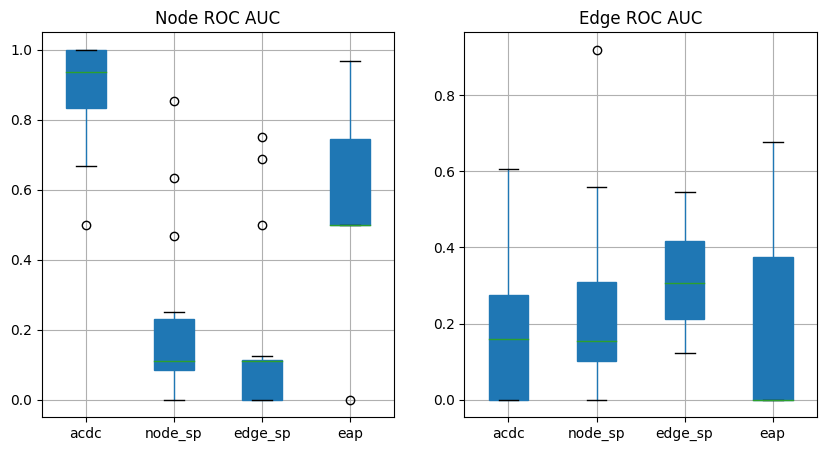

In [52]:
# make box plots for node and edge roc_auc
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

node_roc_df.boxplot(ax=ax[0], 
                    column=["acdc", "node_sp", "edge_sp", "eap"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
edge_roc_df.boxplot(ax=ax[1],
                    column=["acdc", "node_sp", "edge_sp", "eap"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# set title
ax[0].set_title("Node ROC AUC")
ax[1].set_title("Edge ROC AUC")
plt.savefig("plots/acdc_vs_node_sp_vs_edge_sp_roc_auc_boxplot.pdf", bbox_inches='tight', dpi=600, format='pdf')